<img src="./img/HWNI_logo.svg"/>

# Lab - Hypothesis Testing

In [1]:
# makes our plots appear inside Jupyter
%matplotlib inline

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from mpl_toolkits.mplot3d import Axes3D

import util.utils as utils
import util.shared as shared

shared.format_plots()
shared.format_dataframes()

In this lab, we use simulated experiments to investigate the ideas covered in the
[tutorial on Hypothesis Testing](./Tutorial\ -\ Hypothesis\ Testing.ipynb).

The experiment we simulate is inspired by a 
[classic neuroscience experiment](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC1514868/)
performed by Adrian in the 1920s.

At the time, very little of what we now take for granted was known about the behavior of neurons. This early experiment demonstrated that the nerves exiting the cat's foot produced more action potentials when a weight was pressed onto the foot in a manner that depended on the weight.

<img src="./img/adrian_yngve_1926_apparatus.gif">

We'll model this experiment using the random number generators provided with NumPy. The function `run_experiment` below will produce a random spike count using the
[Poisson](https://en.wikipedia.org/wiki/Poisson_distribution)
distribution, which has been used to
[model neural spiking in response to stimuli](https://en.wikipedia.org/wiki/Linear-nonlinear-Poisson_cascade_model),
then compare it to the argument `critical_value`.
The result of the test is returned as number:
`0` if the alternative hypothesis is not accepted
and `1` if the alternative hypothesis is accepted.
If the random spike count is higher than the critical value,
the alternative hypothesis is accepted,
otherwise it is not accepted.

The average value of the random spike count is determined by a parameter.
This parameter is set by two of the arguments to `run_experiment`: `baserate`, which we can think of as setting the average number of spikes when the foot is not being stimulated, and `difference`, which corresponds to the change in this average when the foot is stimulated.

This is a very simple experiment and a very simple statistical test, but it will still allow us to see the major features of hypothesis testing discussed in the tutorial:
true positive rates, false positive rates, and false discovery rates.

In general hypothesis testing terms, the *test statistic* we are using is just the value of the data point that we observed. We might call the measurements from the unstimulated foot the *control measurements* and the measurement from the stimulated foot the *experimental measurement*.

In [2]:
def run_experiment(baserate, difference, critical_value):
    """ run a single experiment where the number of spikes recorded from a 
        neuron firing with rate baserate+difference
        is compared to the critical_value.
        
        returns a 1 if the (randomly-generated) number of spikes
        is higher than the cutoff, otherwise returns a 0
        
        the number of spikes comes from a poisson distribution
    """
    stimulated_spikes = np.random.poisson(lam=baserate+difference)
    
    if stimulated_spikes > critical_value:
        accepted = 1
    else:
        accepted = 0
    
    return accepted

In [3]:
def simulate_experiments(num_experiments, rate, effect_size, critical_value):
    """ simulate num_experiments experiments with run_experiment
        and return the result as a list.
        
        this list has 1s where the null hypothesis was rejected
        and 0s where the null hypothesis was not rejected
    """
    results = np.zeros(num_experiments)
    
    for experiment_idx in range(num_experiments):
        result = run_experiment(rate, effect_size, critical_value)
        results[experiment_idx] = result
    
    return results

## True and False Positive Rates

To start, we'll estimate the true and false positive rates.

#### Q1 In your own words, what are true and false positive rates? What's the difference between a false positive rate and a false discovery rate?

<font color='#1874CD'>  ** The true positive rate of a statistical test tells you the chance of successfully detecting an effect of a given size when using that statistical test. **

** The false positive rate of a statistical test tells you the chance of incorrectly claiming there is an effect, of any size, when there is no effect. **

** The false discovery rate, on the other hand, tells you the chance that any given claimed effect based on that test is a false positive. It crucially requires you to quantify your beliefs regarding whether the effect was real or not from before you collected data (these are called *prior beliefs*)**.

### False Positive Rate

We can estimate the false positive rate by simulating the results of our hypothesis test when the effect size, the difference in average spike counts between stimulated and unstimulated nerves, is 0.

#### Q2 What is the connection between the effect size being 0 and the false positive rate?

<font color='#1874CD'>  ** When the effect size is 0, there is no effect, and so any positive is a false positive. **

The results of the experiments are stored in a list called `nulltrue_results`. Each element is either a `1` or ` 0`, depending on whether the alternative hypothesis was accepted or not. We use this list to calculate the fraction of times that we got a (false) positive result by taking the mean.

#### Q3 Explain why this procedure, taking the mean of a list of 1s and 0s, gives us the fraction of results that are false positives.

<font color='#1874CD'> **The sum of the `nulltrue_results` list is equal to the number of times the alternative hypothesis is accepted, and dividing by the total gives the fraction of times this occurred.**

In [4]:
rate = 10
effect_size = 0

critical_value = 15
num_experiments = 1000

nulltrue_results = simulate_experiments(num_experiments, rate, effect_size,
                                       critical_value)


In [5]:
np.mean(nulltrue_results)

0.052

The false positive rate depends critically (ha!) on the critical value of our test. Remember that the critical value is the value of the test statistic (for us, this is just the observed spike count) above which you reject the null hypothesis.

#### Q4 Make a prediction: will increasing the critical value increase or decrease the false positive rate?

<font color='#1874CD'>  ** Increasing the critical value will decrease the false positive rate. **

Test your prediction in the cell below.

In [6]:
rate = 10
effect_size = 0

critical_value = 17
num_experiments = 1000

nulltrue_results_higher_crit_value = simulate_experiments(num_experiments, rate, effect_size,
                                       critical_value)

In [7]:
np.mean(nulltrue_results_higher_crit_value)

0.005

As can be seen above, changing the critical value changes the false positive rate. The two code cells below will allow us to examine this dependence in detail.

#### Q5 Make a prediction: what will the false positive rate be when the critical value is 0? what about when the critical value is very large?

<font color='#1874CD'>  ** The false positive rate will be 100%, since it's impossible for a neuron to fire fewer than 0 spikes. When the critical value is very large, the false positive rate will be 0, since it will be very unlikely for the neuron to fire that many spikes by chance. **

The first cell below calculates the rate of false positives for experiments with a range of critical values and stores them in a list called `false_positive_rates`.

The cell beneath it will then plot the resulting false positive rates as a function of the critical value.

In [8]:
false_positive_rates = []

rate = 10
effect_size = 0
num_experiments = 100000

critical_values = range(0,21)

for critical_value in critical_values:
    nulltrue_results = simulate_experiments(num_experiments, rate, 0,
                                       critical_value)
    
    false_positive_rates.append(np.mean(nulltrue_results))

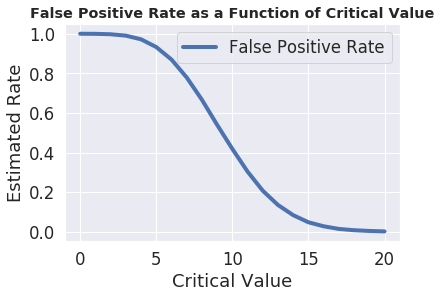

In [9]:
utils.plot_rates(critical_values, false_positive_rates, "False Positive Rate")

## True Positive Rate

We can estimate the true positive rate by simulating the results of our hypothesis test when the effect size is non-zero.

The cell below will produce a list, `nullfalse_results`, just like the `nulltrue_results` list from above. Use it to calculate the true positive rate.

In [10]:
rate = 10
effect_size = 1

critical_value = 15
num_experiments = 10000

nullfalse_results = simulate_experiments(num_experiments, rate, effect_size,
                                       critical_value)

In [11]:
np.mean(nullfalse_results)

0.0899

The true positive rate depends, just like the false positive rate, on the critical value.

#### Q6 Make a prediction: will increasing the critical value increase or decrease the true positive rate?

<font color='#1874CD'>  ** Increasing the critical value will decrease the true positive rate. **

Test your prediction using the cells below.

In [12]:
rate = 10
effect_size = 1

critical_value = 17
num_experiments = 1000

nullfalse_results = simulate_experiments(num_experiments, rate, effect_size,
                                       critical_value)

In [13]:
np.mean(nullfalse_results)

0.036

As above, we can simulate the results for a variety of critical values. The two cells below calculate and then plot the true positive rate with varying critical values. For comparison, the false positive rate is also plotted.

In [14]:
true_positive_rates = []

rate = 10
effect_size = 1
num_experiments = 100000

critical_values = range(0,21)

for critical_value in critical_values:
    nullfalse_results = simulate_experiments(num_experiments, rate, effect_size,
                                       critical_value)
    
    true_positive_rates.append(np.mean(nullfalse_results))

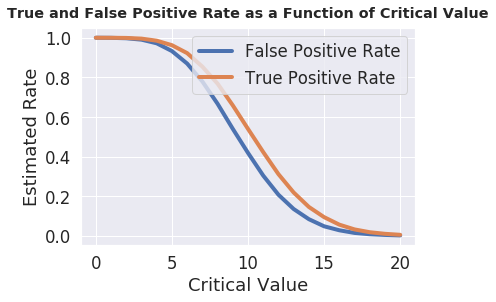

In [15]:
utils.plot_true_and_false_positive_rates(critical_values,
                                         false_positive_rates,
                                         true_positive_rates)

#### Q8 Based on this chart, what would you select as your critical value? There is no single correct answer. Explain your reasoning.

<font color='#1874CD'>  **I would place the critical value just under 10. This is a point where the false positive rate has started to fall while the true positive rate remains high. In fact, if we assume that the chance of the effect being real is $0.5$, this is the region where positive and negative predictive value are roughly equal.**

**This is far from the only answer. The classical statistical approach would be to pick a point where the false positive rate (aka $\alpha$) is just below $0.05$. This results in the more conservative choice of just under $15$. In a context where false positives are more tolerated (e.g. an exploratory study), we want to preserve power, that is keep the true positive rate high, so we'd select the highest value that still gives a true positive rate of at least $0.8$.**

### TPR as a Function of Critical Value and Effect Size

The true positive rate also depends on the actual size of the effect you're looking for.

The code cells below will produce an interactive 3-d plot of the true positive rate as a function of both the effect size and the critical value. Left-clicking and dragging allows you to rotate the plot, while right-clicking and dragging allows you to zoom.

These interactive features are enabled by the `%matplotlib notebook` magic. **If the plot doesn't show up the first time you run the cell, run it again**.

Once you're done with this plot, run the cell underneath it, containing the `%matplotlib inline magic`, to return plots to their normal, non-interactive forms. You can also run the first code cell (the one with all of the imports).

In [16]:
baserate = 10

num_experiments = 10000

critical_values = list(range(5,21))
effect_sizes = list(range(1,16))

TPR = utils.estimate_TPR(baserate, effect_sizes, critical_values, simulate_experiments,
                         num_experiments=num_experiments)

<IPython.core.display.Javascript object>


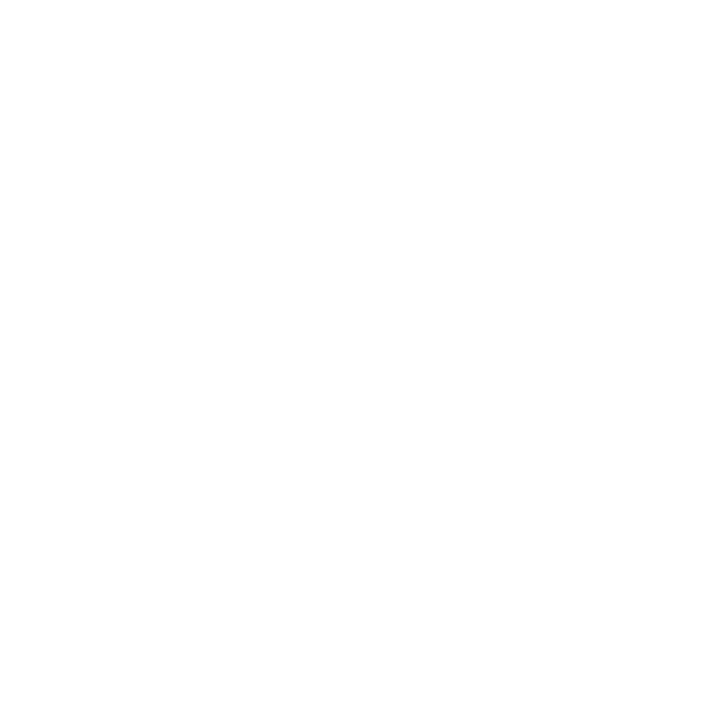

<IPython.core.display.Javascript object>


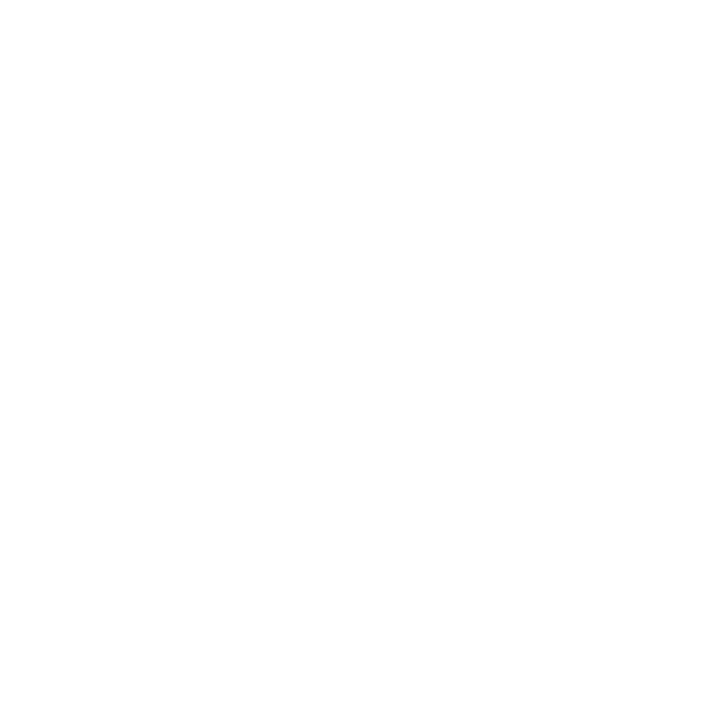

In [17]:
%matplotlib notebook
shared.format_plots()

utils.plot_TPR(critical_values, effect_sizes, TPR)

In [18]:
%matplotlib inline
shared.format_plots()

#### Q9 Explain the shape of this graph: why does the rate go down when you decrease the effect size and hold the critical value constant? why are the extreme values -- closest to 1 (blue) and closest to 0 (red) -- located where they are?

<font color='#1874CD'>  ** As you decrease the effect size, the chance of the spikes in the stimulated neuron being higher than the (fixed) critical value goes down. **

** As described above, when the effect size is low and the critical value is high, then we get very few positives -- this is the red region in the chart above. When the effect size is large and the critical value is small, then it's very unlikely that the number of spikes is less than the critical value -- this is the blue region in the chart above. **

#### Q10 Why can't we calculate a true positive rate for the case where `effect_size == 0`?

<font color='#1874CD'>  ** When the effect size is 0, every result is a false positive, since there is no effect. We could instead calculate the true negative rate for varying choices of critical value. **

## $p$-Value

If we have a good model of our null hypothesis, then we do more than just say whether we reject or fail to reject the null. If we can determine the probability that, if the null hypothesis were true, we'd observe what we observed, then we can express the degree to which our results support the null hypothesis. This probability is called the $p$-value.

In many familiar statistical tests, this model is *parametric* -- we assume some form for the distribution of the data, and therefore the test statistic, under the null hypothesis and then, possibly after measuring some data generated according to the null hypothesis and inferring those parameters, we use the mathematical form of that distribution to calculate the $p$-value.

When we don't know what form to assume the null distribution has, we can use a *nonparametric* method instead. In a non-parametric method, we instead use the data measurements to directly estimate the shape of the null distribution of the test statistic. Since our test statistic is just the number of spikes that we measure in a single experiment, that means we just need to collect a large number of spike counts distributed according to the null hypothesis.

So in our case, we estimate the $p$-value by repeatedly measuring the spike counts from a neuron in an unstimulated cat's foot and then calculating how often that spike count is higher than the spike count from the neuron when the foot is stimulated.

The cell below will simulate measuring the spike counts from an unstimulated foot `number_null_measurements` times, along with a single measurement of the spike count from a stimulated foot.

It then plots a histogram of the spike counts from the unstimulated foot along with a single tick mark indicating the number of spikes measured from the stimulated foot. The bins are selected so that each bin contains a single value of the spike count.

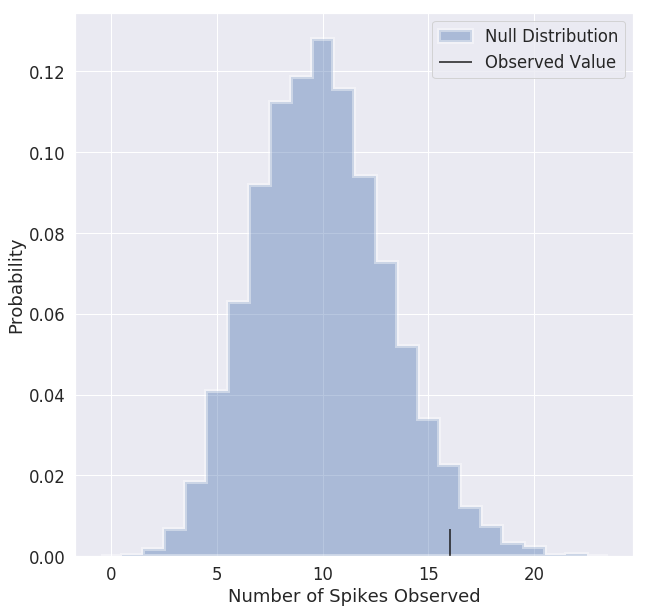

In [19]:
number_null_measurements = 10000

difference = 5
baserate = 10

null_spikes = np.random.poisson(lam=baserate,size=10000)
experiment_spikes = np.random.poisson(lam=baserate+difference)

utils.plot_null_and_result(null_spikes, experiment_spikes)

#### Q11 What is the relationship between this histogram and the null distribution of our test statistic?

<font color='#1874CD'>  ** This histogram is the null distribution of our test statistic! It's the distribution of spike counts we'd expect if the null hypothesis were true, and there was no difference between spike rates in the stimulated and unstimulated neurons. **

A rough guess for the $p$-value can be read directly off the chart above.

#### Q12 Explain how you'd do this.

<font color='#1874CD'>  ** By eye, we can see what fraction of the distribution is at or above the value we observed. **

To calculate the $p$-value precisely, we need the actual heights for this histogram.

#### Q13 How would we calculate the $p$-value from this information?

<font color='#1874CD'>  ** You would add up the heights of each bar from the bar corresponding to the observed value all the way to the end. **

The cell below uses the function `np.histogram` to collect these values and store them in the list `probabilities`. This list acts like a probability mass function: accessing the `i`th element of the list with `probabilities[i]` tells you the fraction of experiments in which `i` spikes occurred.

In [20]:
bins = utils.get_bins(null_spikes, experiment_spikes)

probabilities, bin_edges = np.histogram(null_spikes, bins=bins, density=True)

We can (approximately) calculate the $p$-value by counting the fraction of times that the null experiment produced as many spikes as the non-null experiment did.

#### Q14 Why does this give us the $p$-value?

<font color='#1874CD'>  **The $p$-value is the chance, under the null, that we would see results at least as extreme as what we saw in our experiment. By adding up the total fraction of times that the null experiment produced at least as many spikes as our experiment, we calculate this chance.**

In [21]:
np.sum(probabilities[experiment_spikes:])  # p-value

0.049004900490049005

Simulate a different outcome for the experiment by running the cell below to collect a different random value for `stimulated_spikes`.

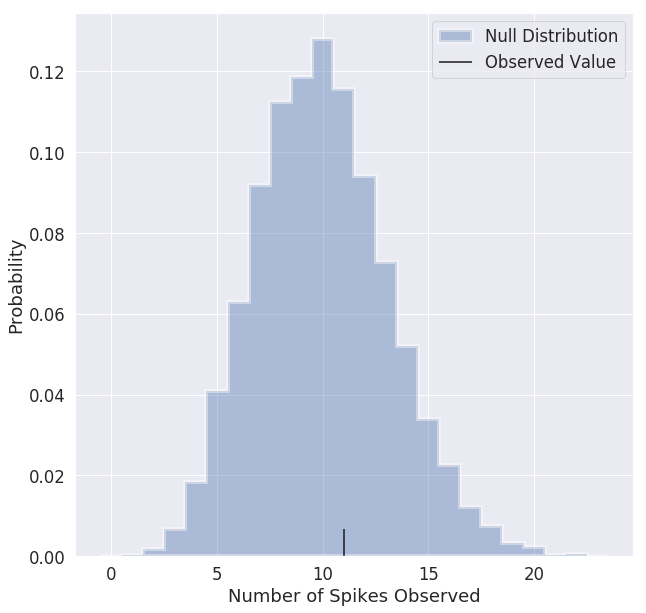

In [22]:
experiment_spikes = np.random.poisson(lam=baserate+difference)
utils.plot_null_and_result(null_spikes, experiment_spikes)

In [23]:
np.sum(probabilities[experiment_spikes:])

0.4176417641764176

#### Q11 Re-calculate the $p$-value. Is it the same or different? Why is this?

<font color='#1874CD'>  ** It's different! The $p$-value is a statistic, and just like any other statistic, it has a sampling distribution, and so takes on different values from experiment to experiment. **

In addition to the probability distribution, the *cumulative distribution function* can be used to represent the chance that a random variable, like a test statistic, takes on some value. The cumulative distribution function, also known as the CDF, takes in a value and returns the probability that the random variable is *less than or equal to* that value. Put another way, it tells you how much probability has *accumulated* as the value of the random variable increases from some minimum up to the current value.

The cell below calculates and plots the cumulative distribution function for the null distribution of our test statistic.

#### Q12 How might this information be used to calculate the $p$-value?

<font color='#1874CD'>  ** The $p$-value is simply 1 minus the value of the CDF at a given point. **

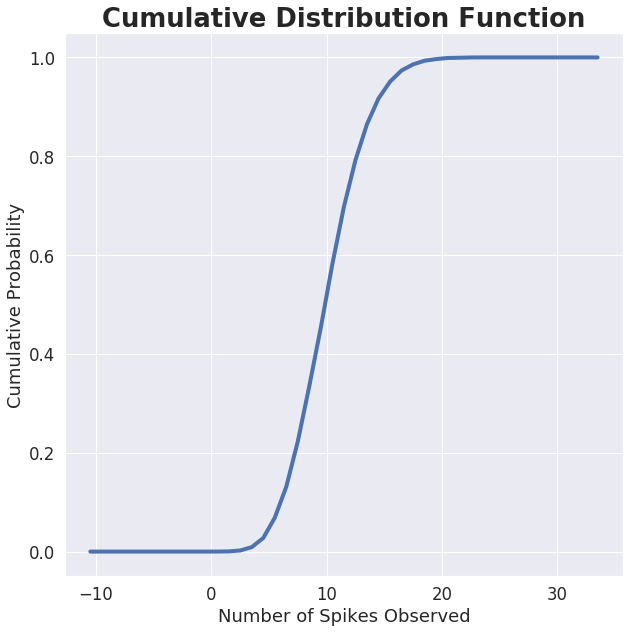

In [24]:
CDF, new_edges = utils.make_CDF(probabilities, bin_edges)
utils.plot_CDF(CDF, new_edges)

Recall that the $p$-value is the probability, under the null hypothesis, that the test statistic takes on a value that is at least as extreme as the measured value.

#### Q13 Based on this, can you determine the chance, when the null hypothesis is true, that the $p$-value is less than 0.5? 0.05? 0?

<font color='#1874CD'>  ** When the null hypothesis is true, the chance that the $p$-value is less than a given value between 0 and 1 is just equal to that value! This is by design: the $p$-value tells us the chance that we'd get a result at least that extreme if the null hypothesis were true. **

Thanks to our simulation framework, we can answer this question directly. The cell below will compute the $p$-value for a large number of experiments and then present the histogram of the results.

In [25]:
baserate = 1000
null_spikes = np.random.poisson(lam=baserate,size=100000)
bins = utils.get_bins(null_spikes,baserate+baserate)

probabilities, bin_edges = np.histogram(null_spikes, bins=bins, density=True)

In [26]:
num_experiments = 10000
effect_size = 1

CDF, new_edges = utils.make_CDF(probabilities, bin_edges)

ps = [1- CDF(experiment_spikes) for experiment_spikes 
                        in np.random.poisson(lam=baserate+effect_size,size=num_experiments)]

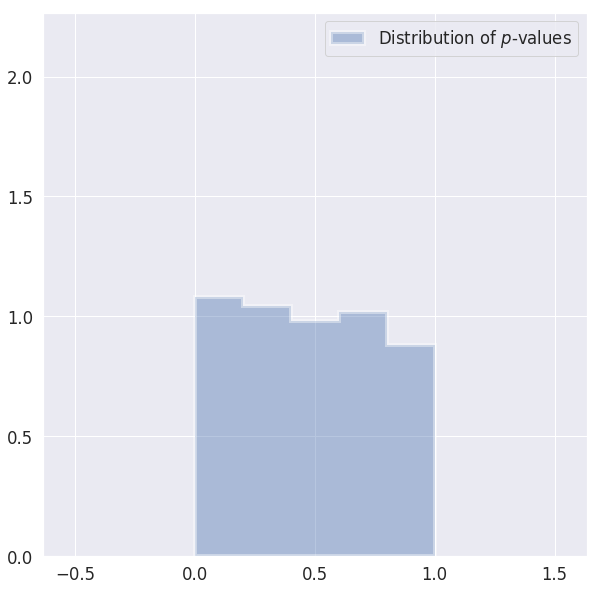

In [27]:
utils.plot_p_distribution(ps)

#### Q14 What shape does this distribution have?

<font color='#1874CD'>  ** It is roughly flat, or *uniform*.  **

Run the code cell above with the `effect_size` set to `10`.

#### Q15 Now what shape does the distribution have?

<font color='#1874CD'>  ** It now has a peak at low values, corresponding to true positives. **

This information about the shape of the distribution of $p$-values can be used to calculate false discovery rates, but only if we run a variety of very similar experiments. For more, see this
[Points of Significance article](http://www.nature.com/nmeth/journal/v11/n4/full/nmeth.2900.html).